In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Use the file with embedding features
FEATURES_PREPPED_FILE = "features_prepped_with_neighbors.csv"
TRAIN_TEST_SPLIT = 0.9
VAL_TEST_SPLIT = 0.9
START_DATE = datetime(2025,9,8) + timedelta(days=28)
BAD_FEATURES = []
TOP_100 = [2637208, 2674067, 2674069, 2677746, 2691590, 2739813, 2813189, 2813194, 2813195, 2819449, 2822887, 2840431, 2841189, 2855586, 2855595, 2857178, 3690505, 3690510, 4039724, 4189521, 4463773, 4580598, 5192206, 5192221, 5192225, 5245545, 5257669, 5658823, 5664444, 5683132, 5683135, 5683137, 5698506, 5698507, 5703921, 5710675, 5730396, 5823149, 5823150, 5850773, 5851707, 5955504, 5955510, 5955515, 5973485, 6049412, 6049413, 6256793, 6451779, 7210406, 7249979, 7379752, 7622814, 7622840, 7635753, 7653413, 7855462, 7869313, 7915951, 7917434, 7917436, 7922326, 8152638, 8152776, 8152803, 8152804, 8217944, 8422222, 8596633, 8858060, 8880222, 8966982, 8971859, 8972128, 9209729, 9245542, 9256674, 9603028, 9603030, 9603032, 9603035, 9656727, 9680118, 9724035, 10041062, 10041066, 10648067, 11061680, 11562016, 11562019, 12120522, 12168743, 12376820, 12376825, 12681178, 12744603, 13419273, 13536691, 14158330, 14234253]

In [3]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
df

,universal_gemrate_id,date,price,grade,half_grade,number_of_bids,source_ebay,source_fanatics,seller_popularity,grade_co_BCCG,...,neighbor_1_avg_price,neighbor_1_similarity,neighbor_2_avg_price,neighbor_2_similarity,neighbor_3_avg_price,neighbor_3_similarity,neighbor_4_avg_price,neighbor_4_similarity,neighbor_5_avg_price,neighbor_5_similarity
138353,4d638efe4a7e89a5d0cfd7458b221e5b015b765e,2025-10-06,10.150348,10.0,0.0,15,1,0,0.459673,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238197,83980eedaecbabb3b51ff6326a4b728463abba15,2025-10-06,8.922658,10.0,0.0,44,1,0,0.460467,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93416,3166336ff3c16833decf8037a73fa5cddccfff54,2025-10-06,6.745236,8.0,0.0,6,1,0,0.000091,0,...,6.993680,0.937648,6.620073,0.913814,8.496990,0.912851,7.863267,0.911207,NaN,NaN
138355,4d638efe4a7e89a5d0cfd7458b221e5b015b765e,2025-10-06,10.146434,10.0,0.0,6,1,0,0.459677,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97065,3369d3fea43cc5a2dd7ea07f024c49d7d1f8408e,2025-10-06,11.593583,10.0,0.0,155,1,0,0.462050,0,...,10.545043,0.992040,9.174779,0.991987,9.285636,0.991316,10.651678,0.991065,9.739293,0.990968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210728,74aa6988e7cf4c4da8e20e2d72ebbd84f1ed77e5,2026-01-01,9.975808,10.0,0.0,32,1,0,0.000017,0,...,7.349541,1.000000,6.915706,0.996506,11.131031,0.996424,6.598345,0.996421,8.832351,0.996343
147928,530f56ac56c06df512180e8cee64b34d14ffdb9b,2026-01-01,9.838949,10.0,0.0,38,1,0,0.000002,0,...,9.324157,0.999998,6.598345,0.991804,8.349628,0.991382,7.456537,0.991250,8.119907,0.991162
311943,ac799f3c0e617de5ad11b1681206e8343497987e,2026-01-01,9.093807,10.0,0.0,13,1,0,0.151030,0,...,8.641912,0.998917,8.711938,0.998801,9.412418,0.998489,8.119907,0.998448,8.289022,0.998441
382583,d9a6987df1419e3be2c1aceecf7e4b7981a9b928,2026-01-01,8.839277,10.0,0.0,14,1,0,0.000039,0,...,8.261037,0.995097,9.244728,0.992527,9.361145,0.990320,8.588580,0.988652,8.675619,0.988613


In [4]:
feature_cols = [col for col in df.columns if col not in ['universal_gemrate_id', 'spec_id', 'date', 'price'] and col not in BAD_FEATURES]
print(f"Total features: {len(feature_cols)}")

Total features: 153


In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

# val_df = val_df.loc[val_df["prev_1_price"].isna()]
# val_df = val_df.dropna(subset=['neighbor_1_avg_price'])
# test_df = test_df.loc[test_df["prev_1_price"].isna()]
# test_df = test_df.dropna(subset=['emb_neighbor_1_price'])
# val_df = val_df.loc[val_df["spec_id"].isin(TOP_100)]
# test_df = test_df.loc[test_df["spec_id"].isin(TOP_100)]
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
val_df["date"].min()

Train: 167861, Val: 16786, Test: 1866


Timestamp('2025-12-15 00:00:00')

In [6]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")

Training set: 167861 samples
Validation set: 16786 samples
Test set: 1866 samples
Number of features: 153


In [7]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.075],
    'n_estimators': [150],
    'min_child_weight': [30],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [5],
    'colsample_bylevel': [0.7],
    'max_delta_step': [0],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_pred = np.exp(y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print("Best MAPE: %0.5f" % best_score)
print("Best Grid:", best_grid)

MAPE: 202744.76%
Best MAPE: 202744.76%
Best MAPE: 2027.44764
Best Grid: {'colsample_bylevel': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 30, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [14:36:42] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [8]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [9]:
y_val = np.exp(y_val)
y_val_pred = best_model.predict(X_val)
y_val_pred = np.exp(y_val_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

simple_percent_error = (np.abs(X_val["prev_1_price"].values - y_val.values) / y_val.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_val_pred - y_val.values) / y_val.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Validation Metrics:
  RMSE: $54,293.37
  MAE:  $6,704.82
  MAPE: 23.91%
  R²:   0.6644

Simple Percent Error Percentiles:
count    15668.000000
mean        96.242832
std         11.906775
min          0.849069
10%         87.281153
20%         99.705878
30%         99.809022
40%         99.856900
50%         99.894930
60%         99.923455
70%         99.946922
80%         99.963693
90%         99.980499
max         99.999587
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    16786.000000
mean        23.911243
std         42.087064
min          0.000943
10%          2.276087
20%          4.726892
30%          7.381205
40%         10.355807
50%         14.104285
60%         18.659574
70%         24.563190
80%         33.538038
90%         51.254246
max       1754.509995
Name: percent_error, dtype: float64


In [10]:
y_test = np.exp(y_test)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Test Metrics:")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  MAE:  ${test_mae:,.2f}")
print(f"  MAPE: {test_mape:.2%}")
print(f"  R²:   {test_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Test Metrics:
  RMSE: $34,480.53
  MAE:  $6,277.44
  MAPE: 21.27%
  R²:   0.7833

Simple Percent Error Percentiles:
count    1798.000000
mean       99.885769
std         0.112041
min        98.313397
10%        99.760398
20%        99.819365
30%        99.858406
40%        99.889640
50%        99.911364
60%        99.935850
70%        99.955018
80%        99.968911
90%        99.982774
max        99.999131
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    1866.000000
mean       21.273104
std        43.345518
min         0.010499
10%         1.954205
20%         4.050629
30%         6.606161
40%         9.307123
50%        12.692196
60%        16.213158
70%        21.340661
80%        28.904512
90%        43.269529
max      1090.152902
Name: percent_error, dtype: float64


In [11]:
y_test

145650    25600.0
224061     3100.0
119339    26769.0
409207     6300.0
128726     6900.0
           ...   
210728    21500.0
147928    18750.0
311943     8900.0
382583     6900.0
308467     9800.0
Name: price, Length: 1866, dtype: float64

In [12]:
y_test_pred

array([32612.729 ,  4958.8745, 23890.014 , ..., 10493.583 ,  3996.7039,
       10813.466 ], shape=(1866,), dtype=float32)

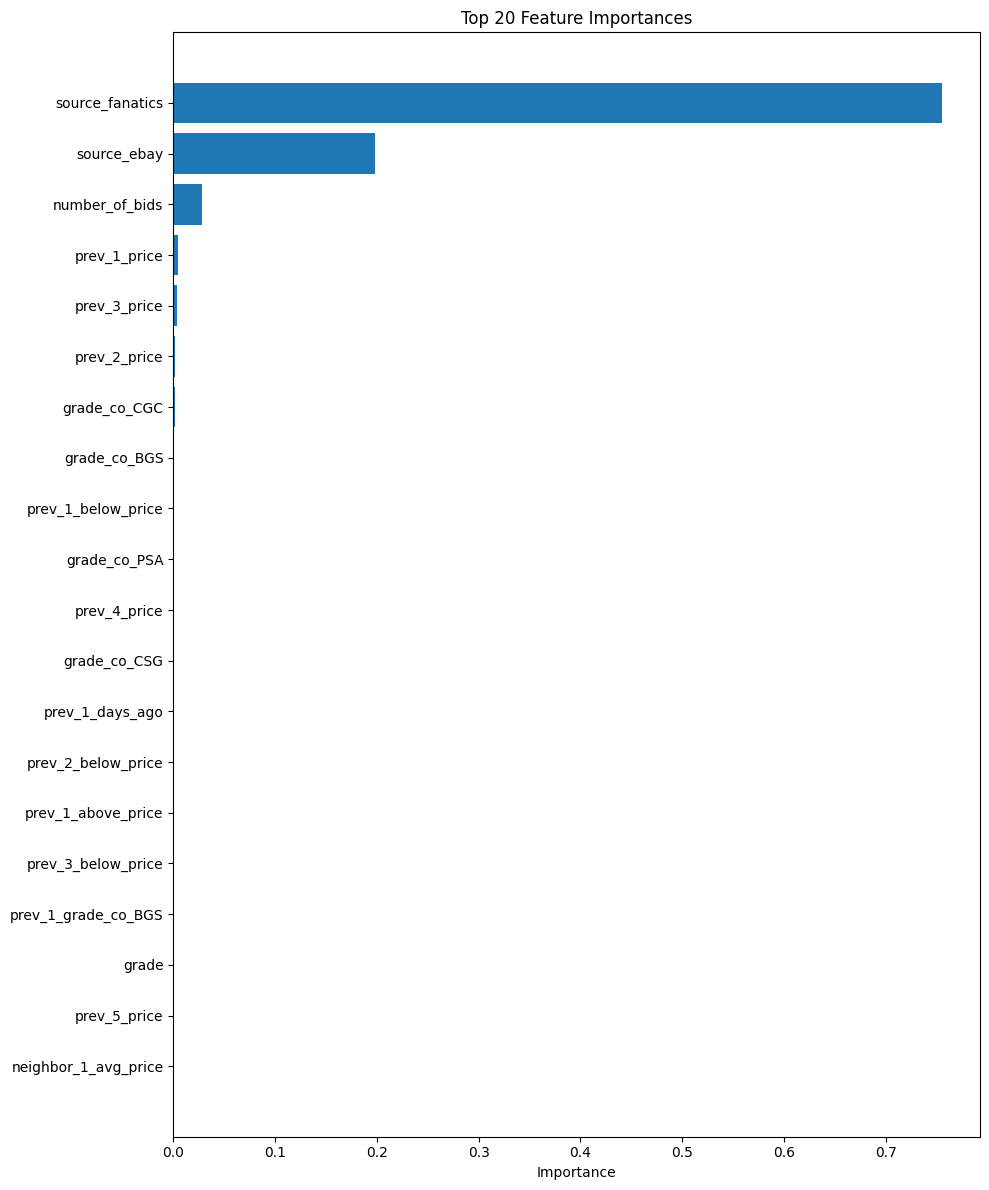

,feature,importance
4,source_fanatics,0.754749
3,source_ebay,0.198108
2,number_of_bids,0.027829
14,prev_1_price,0.004423
26,prev_3_price,0.003600
20,prev_2_price,0.001648
9,grade_co_CGC,0.001562
7,grade_co_BGS,0.000616
103,prev_1_below_price,0.000582
11,grade_co_PSA,0.000468


In [13]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)

In [14]:
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()
importance_df

,feature,importance,importance_cumsum
4,source_fanatics,0.754749,0.754749
3,source_ebay,0.198108,0.952857
2,number_of_bids,0.027829,0.980686
14,prev_1_price,0.004423,0.985109
26,prev_3_price,0.003600,0.988709
...,...,...,...
125,prev_4_below_half_grade,0.000007,0.999988
99,prev_5_above_grade_co_CGC,0.000007,0.999995
98,prev_5_above_grade_co_BGS,0.000005,1.000000
13,grade_co_Unknown,0.000000,1.000000


In [15]:
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['source_ebay',
 'number_of_bids',
 'prev_1_price',
 'prev_3_price',
 'prev_2_price',
 'grade_co_CGC',
 'grade_co_BGS',
 'prev_1_below_price',
 'grade_co_PSA',
 'prev_4_price',
 'grade_co_CSG',
 'prev_1_days_ago',
 'prev_2_below_price',
 'prev_1_above_price',
 'prev_3_below_price',
 'prev_1_grade_co_BGS',
 'grade',
 'prev_5_price',
 'neighbor_1_avg_price',
 'avg_price_4w_ago',
 'neighbor_2_avg_price',
 'prev_1_above_seller_popularity',
 'half_grade',
 'seller_popularity',
 'grade_co_SGC',
 'prev_1_below_seller_popularity',
 'avg_price_3w_ago',
 'prev_4_below_price',
 'prev_1_above_grade_co_BGS',
 'prev_5_below_price',
 'avg_price_2w_ago',
 'index_ema_12',
 'neighbor_3_avg_price',
 'prev_1_below_grade_co_BGS',
 'prev_1_grade_co_CGC',
 'prev_2_above_price',
 'neighbor_4_avg_price',
 'prev_3_half_grade',
 'prev_1_grade_co_PSA',
 'neighbor_5_avg_price',
 'prev_1_half_grade',
 'prev_1_above_days_ago',
 'prev_2_grade_co_BGS',
 'prev_1_above_grade_co_PSA',
 'prev_2_grade_co_PSA',
 'prev_5_bel

## Prediction Intervals with Quantile Regression

Train additional XGBoost models to predict lower and upper bounds using quantile regression.
This provides uncertainty estimates for each prediction.

In [16]:
# Train quantile regression models for prediction intervals
# Lower bound (10th percentile) and upper bound (90th percentile)

LOWER_QUANTILE = 0.1
UPPER_QUANTILE = 0.9

# Create quantile regression models using the same hyperparameters as the best model
quantile_params = best_grid.copy()

# Train lower bound model
model_lower = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=LOWER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_lower.fit(X_train, y_train)
print(f"Lower bound model (q={LOWER_QUANTILE}) trained")

# Train upper bound model
model_upper = XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=UPPER_QUANTILE,
    device='cuda',
    **quantile_params
)
model_upper.fit(X_train, y_train)
print(f"Upper bound model (q={UPPER_QUANTILE}) trained")

Lower bound model (q=0.1) trained
Upper bound model (q=0.9) trained


In [17]:
# Generate prediction intervals for test set
y_test_pred_lower = np.exp(model_lower.predict(X_test))
y_test_pred_upper = np.exp(model_upper.predict(X_test))
y_test_pred_median = y_test_pred  # Use point prediction as median

# Calculate interval coverage (percentage of actual values within predicted interval)
in_interval = (y_test.values >= y_test_pred_lower) & (y_test.values <= y_test_pred_upper)
coverage = in_interval.mean()

# Calculate average interval width
interval_width = y_test_pred_upper - y_test_pred_lower
avg_interval_width = interval_width.mean()
relative_interval_width = (interval_width / y_test_pred_median).mean()

print(f"\nPrediction Interval Metrics (Test Set):")
print(f"  Target Coverage: {(UPPER_QUANTILE - LOWER_QUANTILE) * 100:.0f}%")
print(f"  Actual Coverage: {coverage * 100:.1f}%")
print(f"  Average Interval Width: ${avg_interval_width:,.2f}")
print(f"  Relative Interval Width: {relative_interval_width * 100:.1f}% of predicted price")


Prediction Interval Metrics (Test Set):
  Target Coverage: 80%
  Actual Coverage: 79.0%
  Average Interval Width: $16,130.06
  Relative Interval Width: 71.2% of predicted price


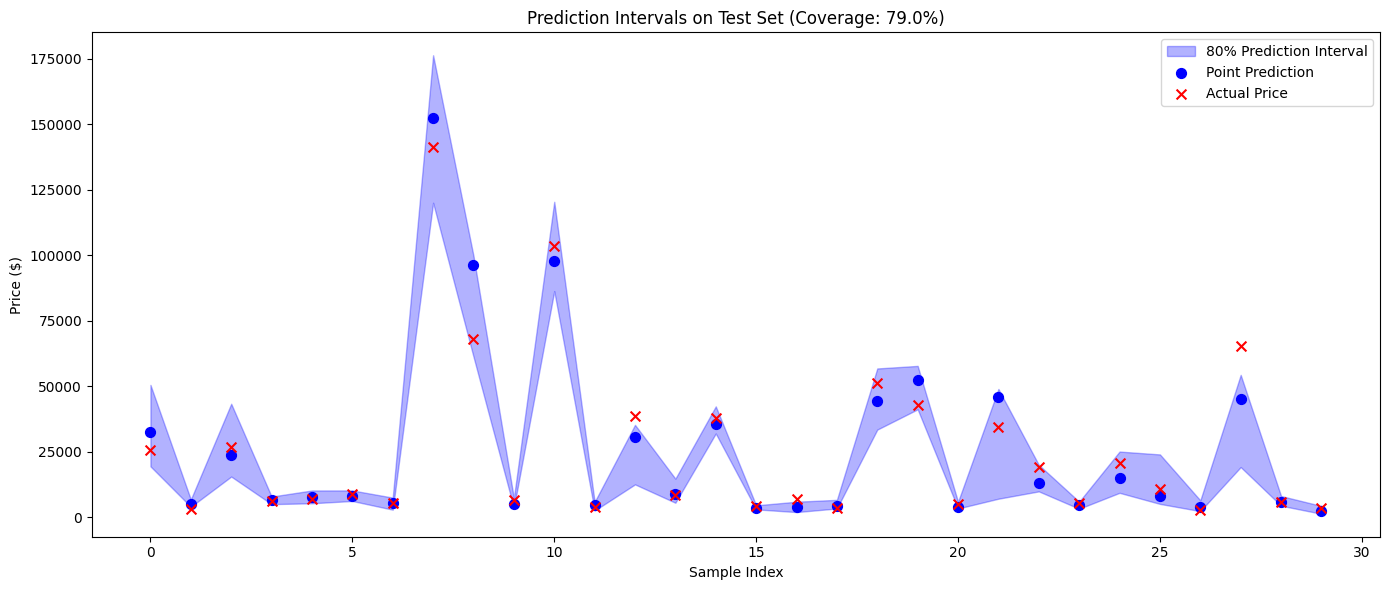

In [18]:
# Visualize prediction intervals for a sample of test predictions
n_samples = min(30, len(y_test))
sample_indices = np.arange(n_samples)

plt.figure(figsize=(14, 6))

# Plot prediction intervals
plt.fill_between(sample_indices, 
                 y_test_pred_lower[:n_samples], 
                 y_test_pred_upper[:n_samples], 
                 alpha=0.3, color='blue', label=f'{int((UPPER_QUANTILE-LOWER_QUANTILE)*100)}% Prediction Interval')

# Plot point predictions
plt.scatter(sample_indices, y_test_pred_median[:n_samples], 
            color='blue', s=50, zorder=3, label='Point Prediction')

# Plot actual values
plt.scatter(sample_indices, y_test.values[:n_samples], 
            color='red', s=50, marker='x', zorder=4, label='Actual Price')

plt.xlabel('Sample Index')
plt.ylabel('Price ($)')
plt.title(f'Prediction Intervals on Test Set (Coverage: {coverage*100:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Create a summary DataFrame with predictions and intervals
predictions_df = pd.DataFrame({
    'actual_price': y_test.values,
    'predicted_price': y_test_pred_median,
    'lower_bound': y_test_pred_lower,
    'upper_bound': y_test_pred_upper,
    'interval_width': interval_width,
    'in_interval': in_interval
})

predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price']
predictions_df['percent_error'] = (np.abs(predictions_df['error']) / predictions_df['actual_price']) * 100

print("\nPredictions with Intervals:")
predictions_df.head(15)


Predictions with Intervals:


,actual_price,predicted_price,lower_bound,upper_bound,interval_width,in_interval,error,percent_error
0,25600.0,32612.728516,19394.625000,50490.394531,31095.769531,True,-7012.728516,27.393471
1,3100.0,4958.874512,3950.792969,6745.090820,2794.297852,False,-1858.874512,59.963694
2,26769.0,23890.013672,15497.791016,43288.902344,27791.111328,True,2878.986328,10.754927
3,6300.0,6699.222656,4966.446777,7860.094727,2893.647949,True,-399.222656,6.336868
4,6900.0,7551.723145,5301.345703,10187.007812,4885.662109,True,-651.723145,9.445263
5,8900.0,8237.992188,6168.829102,10202.749023,4033.919922,True,662.007813,7.438290
6,5500.0,5270.475098,2854.269043,7464.020996,4609.751953,True,229.524902,4.173180
7,141200.0,152311.562500,120015.406250,176321.078125,56305.671875,True,-11111.562500,7.869379
8,68001.0,96137.843750,61257.664062,99762.882812,38505.218750,True,-28136.843750,41.377103
9,6600.0,5057.431641,3540.485107,7252.966309,3712.481201,True,1542.568359,23.372248
